In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from tqdm.notebook import tqdm
from scipy.integrate import solve_ivp
import numpy
import datetime
from datetime import timedelta
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_log_error, mean_squared_error

%matplotlib inline

In [55]:
# Function code refernece from https://www.kaggle.com/anjum48/seir-model-with-intervention

# Susceptible equation
def dS_dt(S, I, R_t, T_inf):
    return -(R_t / T_inf) * I * S

# Exposed equation
def dE_dt(S, E, I, R_t, T_inf, T_inc):
    return (R_t / T_inf) * I * S - (T_inc**-1) * E

# Infected equation
def dI_dt(I, E, T_inc, T_inf):
    return (T_inc**-1) * E - (T_inf**-1) * I

# Recovered/Remove/deceased equation
def dR_dt(I, T_inf):
    return (T_inf**-1) * I

def SEIR_model(t, y, R_t, T_inf, T_inc):
    
    if callable(R_t):
        reproduction = R_t(t)
    else:
        reproduction = R_t
        
    S, E, I, R = y
    
    S_out = dS_dt(S, I, reproduction, T_inf)
    E_out = dE_dt(S, E, I, reproduction, T_inf, T_inc)
    I_out = dI_dt(I, E, T_inc, T_inf)
    R_out = dR_dt(I, T_inf)
    
    return [S_out, E_out, I_out, R_out]

In [56]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train['Date_datetime'] = train['Date'].apply(lambda x: (datetime.datetime.strptime(x, '%Y-%m-%d')))

In [57]:
pop_info = pd.read_csv('population_data.csv')
country_pop = pop_info.query('Type == "Country/Region"')
province_pop = pop_info.query('Type == "Province/State"')
country_lookup = dict(zip(country_pop['Name'], country_pop['Population']))
province_lookup = dict(zip(province_pop['Name'], province_pop['Population']))

In [58]:
def plot_model_and_predict(data, pop, solution, title='SEIR model'):
    sus, exp, inf, rec = solution.y
    
    f = plt.figure(figsize=(16,5))
    ax = f.add_subplot(1,2,1)
    #ax.plot(sus, 'b', label='Susceptible');
    ax.plot(exp, 'y', label='Exposed');
    ax.plot(inf, 'r', label='Infected');
    ax.plot(rec, 'c', label='Recovered/deceased');
    plt.title(title)
    plt.xlabel("Days", fontsize=10);
    plt.ylabel("Fraction of population", fontsize=10);
    plt.legend(loc='best');
    
    ax2 = f.add_subplot(1,2,2)
    preds = np.clip((inf + rec) * pop ,0,np.inf)
    ax2.plot(range(len(data)),preds[:len(data)],label = 'Predict ConfirmedCases')
    ax2.plot(range(len(data)),data['ConfirmedCases'])
    plt.title('Model predict and data')
    plt.ylabel("Population", fontsize=10);
    plt.xlabel("Days", fontsize=10);
    plt.legend(loc='best');

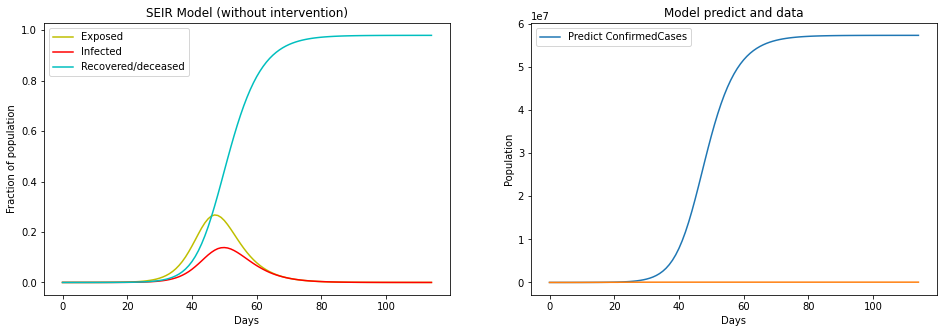

In [59]:
Country = 'Hubei'
N = pop_info[pop_info['Name']==Country]['Population'].tolist()[0] # Hubei Population 

# Load dataset of Hubei
train_loc = train[train['Country_Region']==Country].query('ConfirmedCases > 0')
if len(train_loc)==0:
    train_loc = train[train['Province_State']==Country].query('ConfirmedCases > 0')

n_infected = train_loc['ConfirmedCases'].iloc[0] # start from first comfirmedcase on dataset first date
max_days = len(train_loc)# how many days want to predict

# Initial stat for SEIR model
s = (N - n_infected)/ N
e = 0.
i = n_infected / N
r = 0.

# Define all variable of SEIR model 
T_inc = 5.2  # average incubation period
T_inf = 2.9 # average infectious period
R_0 = 3.954 # reproduction number

## Solve the SEIR model 
sol = solve_ivp(SEIR_model, [0, max_days], [s, e, i, r], args=(R_0, T_inf, T_inc), 
                t_eval=np.arange(max_days))

## Plot result
plot_model_and_predict(train_loc, N, sol, title = 'SEIR Model (without intervention)')


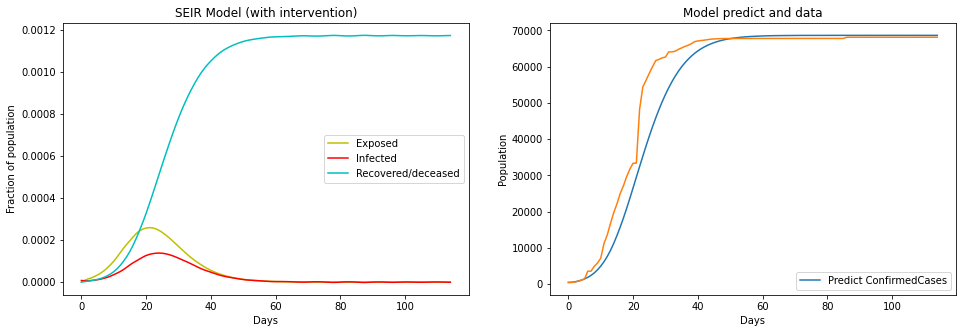

In [60]:
# Define all variable of SEIR model 
T_inc = 5.2  # average incubation period
T_inf = 2.9  # average infectious period

# Define the intervention parameters (fit result, latter will show how to fit)
R_0, cfr, k, L=[ 3.95469597 , 0.04593316 , 3.      ,   15.32328881]

def time_varying_reproduction(t): 
    return R_0 / (1 + (t/L)**k)

sol2 = solve_ivp(SEIR_model, [0, max_days], [s, e, i, r], args=(time_varying_reproduction, T_inf, T_inc), 
                t_eval=np.arange(max_days))

plot_model_and_predict(train_loc, N, sol2, title = 'SEIR Model (with intervention)')

In [61]:
def cumsum_signal(vec):
    temp_val = 0
    vec_new = []
    for i in vec:
        if i > temp_val:
            vec_new.append(i)
            temp_val = i
        else:
            vec_new.append(temp_val)
    return vec_new

In [62]:
# Use a constant reproduction number
def eval_model_const(params, data, population, return_solution=False, forecast_days=0):
    R_0, cfr = params # Paramaters, R0 and cfr 
    N = population # Population of each country
    n_infected = data['ConfirmedCases'].iloc[0] # start from first comfirmedcase on dataset first date
    max_days = len(data) + forecast_days # How many days want to predict
    s, e, i, r = (N - n_infected)/ N, 0, n_infected / N, 0 #Initial stat for SEIR model
    
    # R0 become half after intervention days
    def time_varying_reproduction(t):
        if t > 80: # we set intervention days = 80
            return R_0 * 0.5
        else:
            return R_0
    
    # Solve the SEIR differential equation.
    sol = solve_ivp(SEIR_model, [0, max_days], [s, e, i, r], args=(time_varying_reproduction, T_inf, T_inc),
                    t_eval=np.arange(0, max_days))
    
    sus, exp, inf, rec = sol.y
    # Predict confirmedcase
    y_pred_cases = np.clip((inf + rec) * N ,0,np.inf)
    y_true_cases = data['ConfirmedCases'].values
    
    # Predict Fatalities by remove * fatality rate(cfr)
    y_pred_fat = np.clip(rec*N* cfr, 0, np.inf)
    y_true_fat = data['Fatalities'].values
    
    optim_days = min(20, len(data))  # Days to optimise for
    weights = 1 / np.arange(1, optim_days+1)[::-1]  # Recent data is more heavily weighted
    
    # using mean squre log error to evaluate
    msle_cases = mean_squared_log_error(y_true_cases[-optim_days:], y_pred_cases[-optim_days:], weights)
    msle_fat = mean_squared_log_error(y_true_fat[-optim_days:], y_pred_fat[-optim_days:], weights)
    msle_final = np.mean([msle_cases, msle_fat])
    
    if return_solution:
        return msle_final, sol
    else:
        return msle_final

In [63]:
# Use a Hill decayed reproduction number
def eval_model_decay(params, data, population, return_solution=False, forecast_days=0):
    R_0, cfr, k, L = params # Paramaters, R0 and cfr 
    N = population # Population of each country
    n_infected = data['ConfirmedCases'].iloc[0] # start from first comfirmedcase on dataset first date
    max_days = len(data) + forecast_days # How many days want to predict
    s, e, i, r = (N - n_infected)/ N, 0, n_infected / N, 0 #Initial stat for SEIR model
    
    # https://github.com/SwissTPH/openmalaria/wiki/ModelDecayFunctions   
    # Hill decay. Initial values: R_0=2.2, k=2, L=50
    def time_varying_reproduction(t): 
        return R_0 / (1 + (t/L)**k)
    
    # Solve the SEIR differential equation.
    sol = solve_ivp(SEIR_model, [0, max_days], [s, e, i, r], args=(time_varying_reproduction, T_inf, T_inc),
                    t_eval=np.arange(0, max_days))
    
    sus, exp, inf, rec = sol.y
    # Predict confirmedcase
    y_pred_cases = np.clip((inf + rec) * N ,0,np.inf)
    y_true_cases = data['ConfirmedCases'].values
    
    # Predict Fatalities by remove * fatality rate(cfr)
    y_pred_fat = np.clip(rec*N* cfr, 0, np.inf)
    y_true_fat = data['Fatalities'].values
    
    optim_days = min(20, len(data))  # Days to optimise for
    weights = 1 / np.arange(1, optim_days+1)[::-1]  # Recent data is more heavily weighted
    
    # using mean squre log error to evaluate
    msle_cases = mean_squared_log_error(y_true_cases[-optim_days:], y_pred_cases[-optim_days:], weights)
    msle_fat = mean_squared_log_error(y_true_fat[-optim_days:], y_pred_fat[-optim_days:], weights)
    msle_final = np.mean([msle_cases, msle_fat])
    
    if return_solution:
        return msle_final, sol
    else:
        return msle_final


In [64]:
from matplotlib import dates
import plotly.graph_objects as go

def fit_model_new(data, area_name, initial_guess=[2.2, 0.02, 2, 50], 
              bounds=((1, 20), (0, 0.15), (1, 3), (1, 100)), make_plot=True, decay_mode = None):
    
    if area_name in ['France']:# France last data looks weird, remove it
        train = data.query('ConfirmedCases > 0').copy()[:-1]
    else:
        train = data.query('ConfirmedCases > 0').copy()
    
    ####### Split Train & Valid #######
    valid_data = train[-7:].copy()
    train_data = train[:-7].copy()
    
    ####### If this country have no ConfirmedCase, return 0 #######
    if len(train_data) == 0:
        result_zero = np.zeros((43))
        return pd.DataFrame({'ConfirmedCases':result_zero,'Fatalities':result_zero}), 0 
    
    ####### Load the population of area #######
    try:
        #population = province_lookup[area_name]
        population = pop_info[pop_info['Name']==area_name]['Population'].tolist()[0]
    except IndexError:
        print ('country not in population set, '+str(area_name))
        population = 1000000 
    
    
    if area_name == 'US':
        population = 327200000
        
    if area_name == 'Global':
        population = 7744240900
        
    cases_per_million = train_data['ConfirmedCases'].max() * 10**6 / population
    n_infected = train_data['ConfirmedCases'].iloc[0]
    
    ####### Total case/popuplation below 1, reduce country population #######
    if cases_per_million < 1:
        #print ('reduce pop divide by 100')
        population = population/100
        
    ####### Fit the real data by minimize the MSLE #######
    res_const = minimize(eval_model_const, [2.2, 0.02], bounds=((1, 20), (0, 0.15)),
                         args=(train_data, population, False),
                         method='L-BFGS-B')

    res_decay = minimize(eval_model_decay, initial_guess, bounds=bounds,
                         args=(train_data, population, False),
                         method='L-BFGS-B')
    
    ####### Align the date information #######
    test_end = datetime.datetime.strptime('2020-05-14','%Y-%m-%d')
    test_start = datetime.datetime.strptime('2020-04-02','%Y-%m-%d')
    test_period = (test_end - test_start).days
    train_max = train_data.Date_datetime.max()
    train_all_max = train.Date_datetime.max()
    train_min = train_data.Date_datetime.min()
    add_date = 0
    delta_days =(test_end - train_max).days
    train_add_time=[]

    if train_min > test_start:
        add_date = (train_min-test_start).days
        last = train_min-timedelta(add_date)
        train_add_time = np.arange(last, train_min, dtype='datetime64[D]').tolist()
        train_add_time = pd.to_datetime(train_add_time)
        dates_all = train_add_time.append(pd.to_datetime(np.arange(train_min, test_end+timedelta(1), dtype='datetime64[D]')))
    else:
        dates_all = pd.to_datetime(np.arange(train_min, test_end+timedelta(1), dtype='datetime64[D]'))


    ####### Auto find the best decay function ####### 
    if decay_mode is None:
        if res_const.fun < res_decay.fun :
            msle, sol = eval_model_const(res_const.x, train_data, population, True, delta_days+add_date)
            res = res_const

        else:
            msle, sol = eval_model_decay(res_decay.x, train_data, population, True, delta_days+add_date)
            res = res_decay
            R_0, cfr, k, L = res.x
    else:
        if decay_mode =='day_decay':
            msle, sol = eval_model_const(res_const.x, train_data, population, True, delta_days+add_date)
            res = res_const
        else:
            msle, sol = eval_model_decay(res_decay.x, train_data, population, True, delta_days+add_date)
            res = res_decay
            R_0, cfr, k, L = res.x

    ####### Predict the result by using best fit paramater of SEIR model ####### 
    sus, exp, inf, rec = sol.y
    
    y_pred = pd.DataFrame({
        'ConfirmedCases': cumsum_signal(np.diff((inf + rec) * population, prepend=n_infected).cumsum()),
       # 'ConfirmedCases': [inf[0]*population for i in range(add_date)]+(np.clip((inf + rec) * population,0,np.inf)).tolist(),
       # 'Fatalities': [rec[0]*population for i in range(add_date)]+(np.clip(rec, 0, np.inf) * population * res.x[1]).tolist()
        'Fatalities': cumsum_signal((np.clip(rec * population * res.x[1], 0, np.inf)).tolist())
    })

    y_pred_valid = y_pred.iloc[len(train_data):len(train_data)+len(valid_data)]
    #y_pred_valid = y_pred.iloc[:len(train_data)]
    y_pred_test = y_pred.iloc[-(test_period+1):]
    #y_true_valid = train_data[['ConfirmedCases', 'Fatalities']]
    y_true_valid = valid_data[['ConfirmedCases', 'Fatalities']]
    #print (len(y_pred),train_min)
    #print (y_true_valid['ConfirmedCases'])
    #print (y_pred_valid['ConfirmedCases'])
    ####### Calculate MSLE ####### 
    valid_msle_cases = mean_squared_log_error(y_true_valid['ConfirmedCases'], y_pred_valid['ConfirmedCases'])
    valid_msle_fat = mean_squared_log_error(y_true_valid['Fatalities'], y_pred_valid['Fatalities'])
    valid_msle = np.mean([valid_msle_cases, valid_msle_fat])
    
    ####### Plot the fit result of train data and forecast after 300 days ####### 
    if make_plot:
        if len(res.x)<=2:
            print(f'Validation MSLE: {valid_msle:0.5f}, using intervention days decay, Reproduction number(R0) : {res.x[0]:0.5f}, Fatal rate : {res.x[1]:0.5f}')
        else:
            print(f'Validation MSLE: {valid_msle:0.5f}, using Hill decay, Reproduction number(R0) : {res.x[0]:0.5f}, Fatal rate : {res.x[1]:0.5f}, K : {res.x[2]:0.5f}, L: {res.x[3]:0.5f}')
        
        ####### Plot the fit result of train data dna SEIR model trends #######

        f = plt.figure(figsize=(16,5))
        ax = f.add_subplot(1,2,1)
        ax.plot(exp, 'y', label='Exposed');
        ax.plot(inf, 'r', label='Infected');
        ax.plot(rec, 'c', label='Recovered/deceased');
        plt.title('SEIR Model Trends')
        plt.xlabel("Days", fontsize=10);
        plt.ylabel("Fraction of population", fontsize=10);
        plt.legend(loc='best');
        #train_date_remove_year = train_data['Date_datetime'].apply(lambda date:'{:%m-%d}'.format(date))
        ax2 = f.add_subplot(1,2,2)
        xaxis = train_data['Date_datetime'].tolist()
        xaxis = dates.date2num(xaxis)
        hfmt = dates.DateFormatter('%m\n%d')
        ax2.xaxis.set_major_formatter(hfmt)
        ax2.plot(np.array(train_data['Date_datetime'], dtype='datetime64[D]'),train_data['ConfirmedCases'],label='Confirmed Cases (train)', c='g')
        ax2.plot(np.array(train_data['Date_datetime'], dtype='datetime64[D]'), y_pred['ConfirmedCases'][:len(train_data)],label='Cumulative modeled infections', c='r')
        ax2.plot(np.array(valid_data['Date_datetime'], dtype='datetime64[D]'), y_true_valid['ConfirmedCases'],label='Confirmed Cases (valid)', c='b')
        ax2.plot(np.array(valid_data['Date_datetime'], dtype='datetime64[D]'),y_pred_valid['ConfirmedCases'],label='Cumulative modeled infections (valid)', c='y')
        plt.title('Real ConfirmedCase and Predict ConfirmedCase')
        plt.legend(loc='best');
        plt.show()
            
        ####### Forecast 300 days after by using the best paramater of train data #######
        if len(res.x)>2:
            msle, sol = eval_model_decay(res.x, train_data, population, True, 300)
        else:
            msle, sol = eval_model_const(res.x, train_data, population, True, 300)
        
        sus, exp, inf, rec = sol.y
        
        y_pred = pd.DataFrame({
            'ConfirmedCases': cumsum_signal(np.diff((inf + rec) * population, prepend=n_infected).cumsum()),
            'Fatalities': cumsum_signal(np.clip(rec, 0, np.inf) * population * res.x[1])
        })
        
        ####### Plot 300 days after of each country #######
        start = train_min
        end = start + timedelta(len(y_pred))
        time_array = np.arange(start, end, dtype='datetime64[D]')

        max_day = numpy.where(inf == numpy.amax(inf))[0][0]
        where_time = time_array[max_day]
        pred_max_day = y_pred['ConfirmedCases'][max_day]
        xy_show_max_estimation = (where_time, max_day)
        
        con = y_pred['ConfirmedCases']
        max_day_con = numpy.where(con == numpy.amax(con))[0][0] # Find the max confimed case of each country
        max_con = numpy.amax(con)
        where_time_con = time_array[len(time_array)-50]
        xy_show_max_estimation_confirmed = (where_time_con, max_con)
        
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=time_array, y=y_pred['ConfirmedCases'].astype(int),
                            mode='lines',
                            line = dict(color='red'),
                            name='Estimation Confirmed Case Start from '+ str(start.date())+ ' to ' +str(end.date())))
        
        fig.add_trace(go.Scatter(x=time_array[:len(train)], y=train['ConfirmedCases'],
                            mode='lines',
                            name='Confirmed case until '+ str(train_all_max.date()),line = dict(color='green', width=4)))
        fig.add_annotation(
            x=where_time_con,
            y=max_con-(max_con/30),
            showarrow=False,
            text="Estimate Max Case around:" +str(int(max_con)),
            font=dict(
                color="Blue",
                size=15
            ))
        fig.add_annotation(
            x=time_array[len(train)-1],
            y=train['ConfirmedCases'].tolist()[-1],
            showarrow=True,
            text=f"Real Max ConfirmedCase: " +str(int(train['ConfirmedCases'].tolist()[-1]))) 
        
        fig.add_annotation(
            x=where_time,
            y=pred_max_day,
            text='Infect start decrease from: ' + str(where_time))   
        fig.update_layout(title='Estimate Confirmed Case ,'+area_name+' Total population ='+ str(int(population)), legend_orientation="h")
        fig.show()
        
        #df = pd.DataFrame({'Values': train_data['ConfirmedCases'].tolist()+y_pred['ConfirmedCases'].tolist(),'Date_datatime':time_array[:len(train_data)].tolist()+time_array.tolist(),
        #           'Real/Predict': ['ConfirmedCase' for i in range(len(train_data))]+['PredictCase' for i in range(len(y_pred))]})
        #fig = px.line(df, x="Date_datatime", y="Values",color = 'Real/Predict')
        #fig.show()
        #plt.figure(figsize = (16,7))
        #plt.plot(time_array[:len(train_data)],train_data['ConfirmedCases'],label='Confirmed case until '+ str(train_max.date()),color='g', linewidth=3.0)
        #plt.plot(time_array,y_pred['ConfirmedCases'],label='Estimation Confirmed Case Start from '+ str(start.date())+ ' to ' +str(end.date()),color='r', linewidth=1.0)
        #plt.annotate('Infect start decrease from: ' + str(where_time), xy=xy_show_max_estimation, size=15, color="black")
        #plt.annotate('max Confirmedcase: ' + str(int(max_con)), xy=xy_show_max_estimation_confirmed, size=15, color="black")
        #plt.title('Estimate Confirmed Case '+area_name+' Total population ='+ str(int(population)))
        #plt.legend(loc='lower right')
        #plt.show()


    return y_pred_test, valid_msle

In [65]:
country = 'Global'
country_pd_train2 = train.groupby(['Date']).sum().reset_index()
country_pd_train2['Date_datetime'] = country_pd_train2['Date'].apply(lambda x: (datetime.datetime.strptime(x, '%Y-%m-%d')))
a,b = fit_model_new(country_pd_train2,country,make_plot=True)

country not in population set, Global


c:\users\ilakkiya\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass sample_weight=[0.05       0.05263158 0.05555556 0.05882353 0.0625     0.06666667
 0.07142857 0.07692308 0.08333333 0.09090909 0.1        0.11111111
 0.125      0.14285714 0.16666667 0.2        0.25       0.33333333
 0.5        1.        ] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
c:\users\ilakkiya\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass sample_weight=[0.05       0.05263158 0.05555556 0.05882353 0.0625     0.06666667
 0.07142857 0.07692308 0.08333333 0.09090909 0.1        0.11111111
 0.125      0.14285714 0.16666667 0.2        0.25       0.33333333
 0.5        1.        ] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional argume

ValueError: Found input variables with inconsistent numbers of samples: [7, 6]

In [40]:
validation_scores = pd.DataFrame({'country/state':validation_country,'country':validation_county,'MSLE':validation_scores})
validation_scores.sort_values(by=['MSLE'], ascending=False).head(20)

,country/state,country,MSLE
